TANMAY JAGTAP

**Step 1 : Installing all necessary libraries**




In [1]:
# Basic data + visualization libraries
!pip install imbalanced-learn xgboost lightgbm shap --quiet


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

**Step 2 : Uploading and reading the dataset**

In [3]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [4]:
file_path = "/content/drive/MyDrive/Fraud_Analysis_Dataset.csv"
df = pd.read_csv(file_path)
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud
0,1,TRANSFER,181.0,C1305486145,181.0,0.0,C553264065,0.0,0.0,1
1,1,CASH_OUT,181.0,C840083671,181.0,0.0,C38997010,21182.0,0.0,1
2,1,TRANSFER,2806.0,C1420196421,2806.0,0.0,C972765878,0.0,0.0,1
3,1,CASH_OUT,2806.0,C2101527076,2806.0,0.0,C1007251739,26202.0,0.0,1
4,1,TRANSFER,20128.0,C137533655,20128.0,0.0,C1848415041,0.0,0.0,1


**Step 3 : Exploratory Data Analysis**


In [5]:
# DATA OVERVIEW
print("Dataset Shape:", df.shape)
print("\nColumn Names:\n", df.columns.tolist())
print("\nData Types:\n")
print(df.dtypes)

Dataset Shape: (11142, 10)

Column Names:
 ['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig', 'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud']

Data Types:

step                int64
type               object
amount            float64
nameOrig           object
oldbalanceOrg     float64
newbalanceOrig    float64
nameDest           object
oldbalanceDest    float64
newbalanceDest    float64
isFraud             int64
dtype: object


In [6]:
# MISSING & UNIQUE VALUES
print("Columns with missing values:\n", df.isnull().sum()[df.isnull().sum() > 0])
print("\nUnique values per column:\n", df.nunique())

Columns with missing values:
 Series([], dtype: int64)

Unique values per column:
 step                 95
type                  5
amount            10565
nameOrig          11142
oldbalanceOrg      7806
newbalanceOrig     5914
nameDest           7508
oldbalanceDest     4531
newbalanceDest     2030
isFraud               2
dtype: int64


TRANSACTION TYPE ANALYSIS



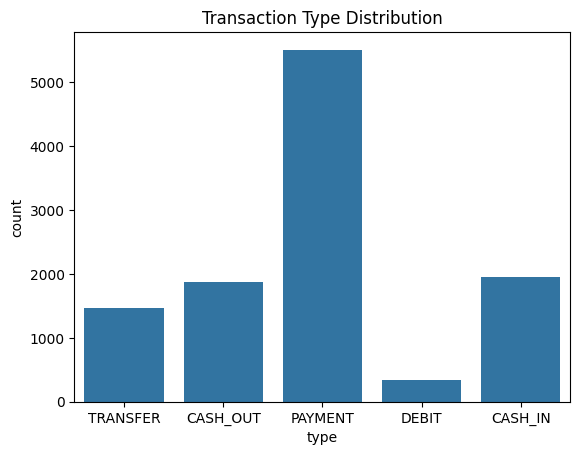

In [7]:
# Overall distribution of transaction types
sns.countplot(x='type', data=df)
plt.title('Transaction Type Distribution')
plt.show()

type
TRANSFER    0.385246
CASH_OUT    0.308926
CASH_IN     0.000000
DEBIT       0.000000
PAYMENT     0.000000
Name: isFraud, dtype: float64


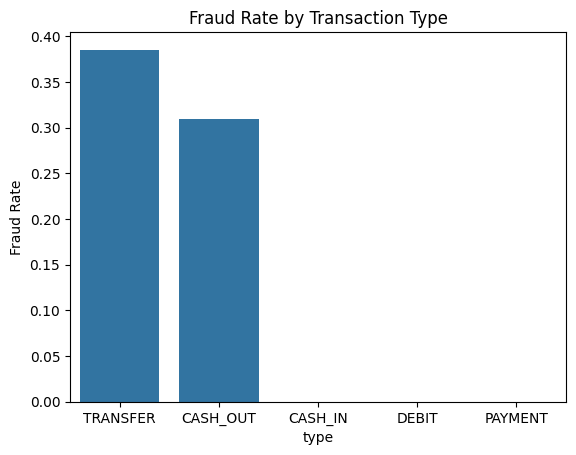

In [8]:
# Fraud rate for each transaction type
type_rate = df.groupby('type')['isFraud'].mean().sort_values(ascending=False)
print(type_rate)

sns.barplot(x=type_rate.index, y=type_rate.values)
plt.title('Fraud Rate by Transaction Type')
plt.ylabel('Fraud Rate')
plt.xlabel('type')
plt.show()

TRANSACTION AMOUNT ANALYSIS

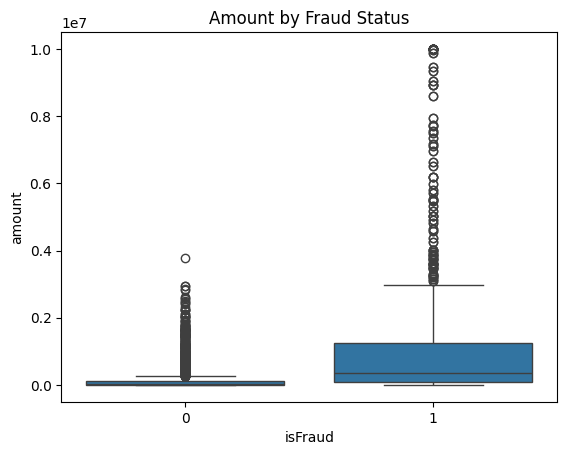

In [9]:
# Boxplot of amount by fraud status
sns.boxplot(x='isFraud', y='amount', data=df)
plt.title('Amount by Fraud Status')
plt.show()

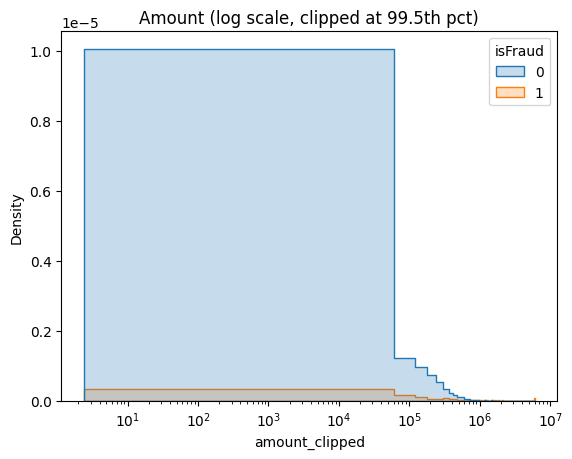

In [10]:
# Histogram of amounts
amt = df['amount'].clip(upper=df['amount'].quantile(0.995))
sns.histplot(data=df.assign(amount_clipped=amt), x='amount_clipped', hue='isFraud', bins=100, element='step', stat='density')
plt.yscale('linear')
plt.xscale('log')
plt.title('Amount (log scale, clipped at 99.5th pct)')
plt.show()

CORRELATION ANALYSIS

In [11]:
# Correlation values with target variable
num_df = df.select_dtypes(include=['int64','float64'])
corr_with_target = num_df.corr()['isFraud'].sort_values(ascending=False)
print(corr_with_target)

isFraud           1.000000
step              0.831961
amount            0.435490
oldbalanceOrg     0.046445
newbalanceDest   -0.002864
oldbalanceDest   -0.056575
newbalanceOrig   -0.127912
Name: isFraud, dtype: float64


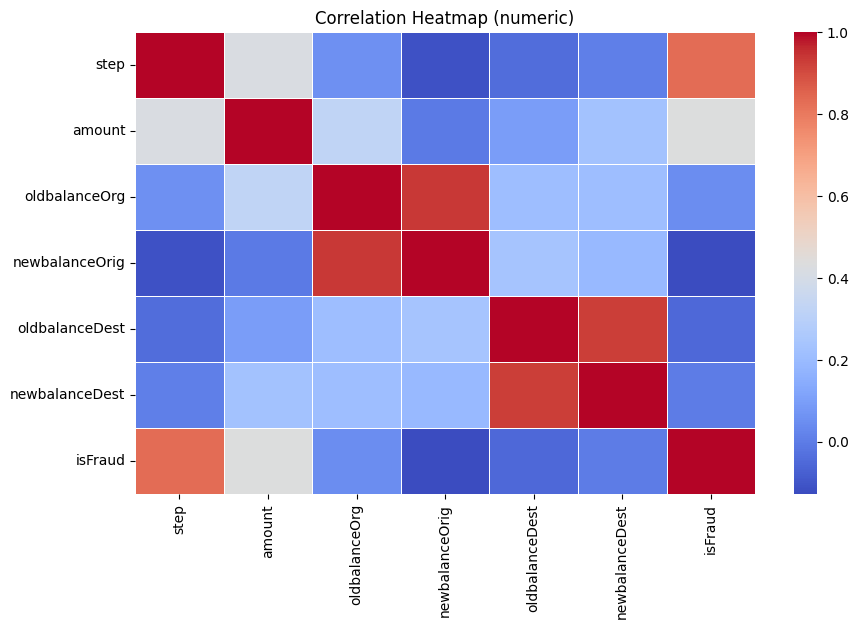

In [12]:
# Full numeric correlation heatmap
corr_mat = num_df.corr()
plt.figure(figsize=(10,6))
sns.heatmap(corr_mat, annot=False, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap (numeric)')
plt.show()

TIME-BASED ANALYSIS

Fraud rate by hour:
hour
0     1.000000
1     0.016801
2     0.045541
3     0.058419
4     0.044750
5     0.043541
6     0.026159
7     0.015604
8     1.000000
9     1.000000
10    1.000000
11    1.000000
12    1.000000
13    1.000000
14    1.000000
15    1.000000
16    1.000000
17    1.000000
18    1.000000
19    1.000000
20    1.000000
21    1.000000
22    1.000000
23    1.000000
Name: isFraud, dtype: float64

Fraud rate by day:
day
0    0.025816
1    1.000000
2    1.000000
3    1.000000
Name: isFraud, dtype: float64


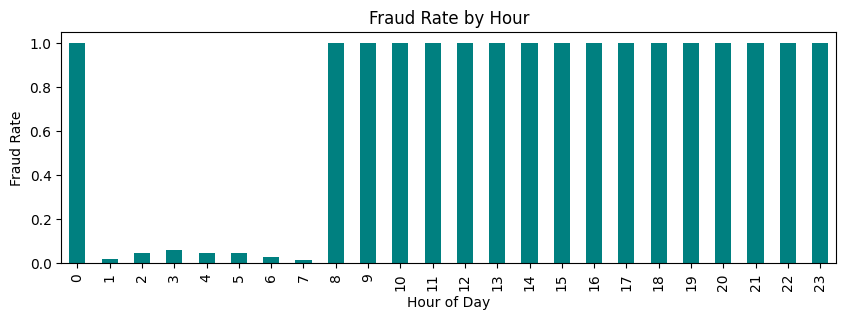

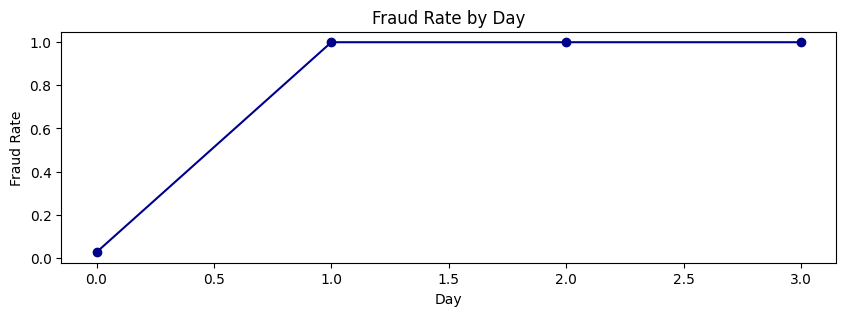

In [13]:
# Deriving hour and day from step
df['hour'] = df['step'] % 24
df['day']  = (df['step'] // 24).astype(int)

# Fraud rate by hour and day
hour_rate = df.groupby('hour')['isFraud'].mean()
day_rate  = df.groupby('day')['isFraud'].mean()

print("Fraud rate by hour:")
print(hour_rate.sort_index())
print("\nFraud rate by day:")
print(day_rate.sort_index())

# Plotting hourly pattern
plt.figure(figsize=(10,3))
hour_rate.plot(kind='bar', color='teal', title='Fraud Rate by Hour')
plt.xlabel('Hour of Day')
plt.ylabel('Fraud Rate')
plt.show()

# Plotting daily pattern
plt.figure(figsize=(10,3))
day_rate.plot(kind='line', color='darkblue', marker='o', title='Fraud Rate by Day')
plt.xlabel('Day')
plt.ylabel('Fraud Rate')
plt.show()


**Step 4: Feature Engineering and Data Preparation**

In [14]:
# Removed non-predictive identifier columns
df = df.drop(columns=['nameOrig', 'nameDest'])

# Created new numerical features to capture balance movement
df['balanceDiffOrig'] = df['oldbalanceOrg'] - df['newbalanceOrig']
df['balanceDiffDest'] = df['newbalanceDest'] - df['oldbalanceDest']
df['balanceChange'] = df['amount'] - df['balanceDiffOrig']

# Checked the new engineered columns
df[['balanceDiffOrig', 'balanceDiffDest', 'balanceChange']].head()

,balanceDiffOrig,balanceDiffDest,balanceChange
0,181.0,0.0,0.0
1,181.0,-21182.0,0.0
2,2806.0,0.0,0.0
3,2806.0,-26202.0,0.0
4,20128.0,0.0,0.0


In [15]:
# One-hot encoded the 'type' column
df = pd.get_dummies(df, columns=['type'], drop_first=True)

# Verified new columns after encoding
df.columns.tolist()

['step',
 'amount',
 'oldbalanceOrg',
 'newbalanceOrig',
 'oldbalanceDest',
 'newbalanceDest',
 'isFraud',
 'hour',
 'day',
 'balanceDiffOrig',
 'balanceDiffDest',
 'balanceChange',
 'type_CASH_OUT',
 'type_DEBIT',
 'type_PAYMENT',
 'type_TRANSFER']

In [16]:
# Split data into features and target
X = df.drop(columns=['isFraud'])
y = df['isFraud']

# Created stratified train-test split for balanced class distribution
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Checked split sizes
print("Training set:", X_train.shape)
print("Test set:", X_test.shape)


Training set: (8913, 15)
Test set: (2229, 15)


**Step 5: Data Modelling**

In [17]:
# Trained a baseline Logistic Regression with scaling and class weights
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix

logit_pipe = Pipeline([
    ('scaler', StandardScaler(with_mean=False)),
    ('clf', LogisticRegression(max_iter=1000, class_weight='balanced', n_jobs=-1))
])

logit_pipe.fit(X_train, y_train)

# Evaluated baseline performance
y_proba_lr = logit_pipe.predict_proba(X_test)[:, 1]
y_pred_lr  = logit_pipe.predict(X_test)

print("ROC-AUC (LR):", roc_auc_score(y_test, y_proba_lr))
print("\nClassification Report (LR):\n", classification_report(y_test, y_pred_lr, digits=4))
print("Confusion Matrix (LR):\n", confusion_matrix(y_test, y_pred_lr))

ROC-AUC (LR): 0.9914384912806755

Classification Report (LR):
               precision    recall  f1-score   support

           0     0.9960    0.9850    0.9905      2001
           1     0.8800    0.9649    0.9205       228

    accuracy                         0.9830      2229
   macro avg     0.9380    0.9750    0.9555      2229
weighted avg     0.9841    0.9830    0.9833      2229

Confusion Matrix (LR):
 [[1971   30]
 [   8  220]]


In [18]:
# Trained a Random Forest classifier for stronger nonlinear performance
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

rf_model.fit(X_train, y_train)

# Evaluated Random Forest performance
y_proba_rf = rf_model.predict_proba(X_test)[:, 1]
y_pred_rf  = rf_model.predict(X_test)

print("ROC-AUC (RF):", roc_auc_score(y_test, y_proba_rf))
print("\nClassification Report (RF):\n", classification_report(y_test, y_pred_rf, digits=4))
print("Confusion Matrix (RF):\n", confusion_matrix(y_test, y_pred_rf))

ROC-AUC (RF): 0.9999649298157939

Classification Report (RF):
               precision    recall  f1-score   support

           0     0.9995    1.0000    0.9998      2001
           1     1.0000    0.9956    0.9978       228

    accuracy                         0.9996      2229
   macro avg     0.9998    0.9978    0.9988      2229
weighted avg     0.9996    0.9996    0.9996      2229

Confusion Matrix (RF):
 [[2001    0]
 [   1  227]]


In [19]:
# Trained an XGBoost classifier to compare gradient boosting performance
from xgboost import XGBClassifier

xgb_model = XGBClassifier(
    n_estimators=400,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric='auc',
    random_state=42,
    n_jobs=-1
)

xgb_model.fit(X_train, y_train)

# Evaluated XGBoost performance
y_proba_xgb = xgb_model.predict_proba(X_test)[:, 1]
y_pred_xgb  = xgb_model.predict(X_test)

print("ROC-AUC (XGB):", roc_auc_score(y_test, y_proba_xgb))
print("\nClassification Report (XGB):\n", classification_report(y_test, y_pred_xgb, digits=4))
print("Confusion Matrix (XGB):\n", confusion_matrix(y_test, y_pred_xgb))

ROC-AUC (XGB): 0.9999890405674355

Classification Report (XGB):
               precision    recall  f1-score   support

           0     0.9995    1.0000    0.9998      2001
           1     1.0000    0.9956    0.9978       228

    accuracy                         0.9996      2229
   macro avg     0.9998    0.9978    0.9988      2229
weighted avg     0.9996    0.9996    0.9996      2229

Confusion Matrix (XGB):
 [[2001    0]
 [   1  227]]


In [20]:
import joblib
joblib.dump(xgb_model, "xgb_fraud_model.joblib")

['xgb_fraud_model.joblib']

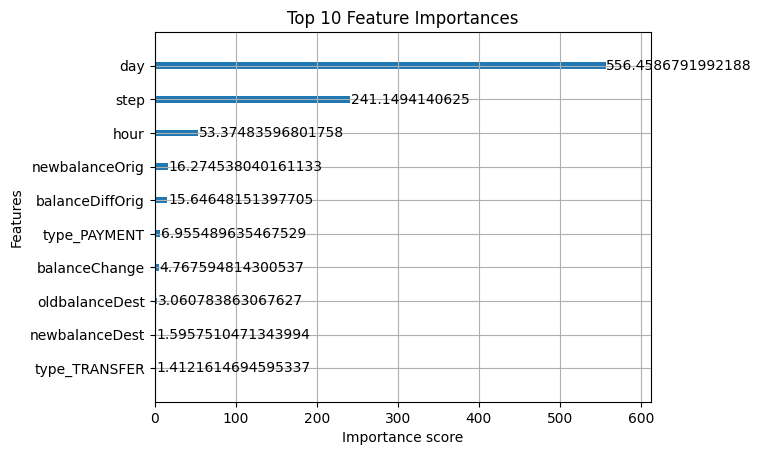

In [21]:
# Displayed top features influencing XGBoost predictions
import xgboost as xgb

xgb.plot_importance(xgb_model, max_num_features=10, importance_type='gain', title='Top 10 Feature Importances')
plt.show()


**STEP 5:Model Selection**

In [22]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

def evaluate_model(name, model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]
    return {
        'Model': name,
        'ROC-AUC': roc_auc_score(y_test, y_proba),
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision (Fraud)': precision_score(y_test, y_pred),
        'Recall (Fraud)': recall_score(y_test, y_pred),
        'F1-Score (Fraud)': f1_score(y_test, y_pred)
    }

# Collected metrics for all models
results = []
results.append(evaluate_model('Logistic Regression', logit_pipe, X_test, y_test))
results.append(evaluate_model('Random Forest', rf_model, X_test, y_test))
results.append(evaluate_model('XGBoost', xgb_model, X_test, y_test))

# Created summary dataframe
model_results = pd.DataFrame(results)
model_results

,Model,ROC-AUC,Accuracy,Precision (Fraud),Recall (Fraud),F1-Score (Fraud)
0,Logistic Regression,0.991438,0.982952,0.88,0.964912,0.920502
1,Random Forest,0.999965,0.999551,1.00,0.995614,0.997802
2,XGBoost,0.999989,0.999551,1.00,0.995614,0.997802


In [23]:
# Set business cost parameters
cost_chargeback = X_test.loc[y_test==1, 'amount'].mean()  # avg loss if a fraud is missed (FN)
cost_review     = 50.0                                    # cost to review a flagged legit txn (FP)

# Choose model to deploy (pick best so far)
deploy_model = xgb_model

# Compute probabilities and sweep thresholds
from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_auc_score

y_proba = deploy_model.predict_proba(X_test)[:, 1]
thrs = np.linspace(0, 1, 101)

losses = []
cms = []
for t in thrs:
    y_pred_t = (y_proba >= t).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred_t).ravel()
    total_loss = fn * cost_chargeback + fp * cost_review
    losses.append(total_loss)
    cms.append((tn, fp, fn, tp))

# Pick threshold with minimum estimated loss
best_idx = int(np.argmin(losses))
best_thr = float(thrs[best_idx])
best_cm  = cms[best_idx]
best_loss = float(losses[best_idx])

print("Chosen threshold:", round(best_thr, 4))
print("Confusion matrix at chosen threshold [tn, fp, fn, tp]:", best_cm)
print("Estimated total loss at chosen threshold:", round(best_loss, 2))

# Also report baseline at 0.5 for comparison
base_thr = 0.5
tn, fp, fn, tp = confusion_matrix(y_test, (y_proba >= base_thr).astype(int)).ravel()
base_loss = fn * cost_chargeback + fp * cost_review

print("\nBaseline threshold (0.5) loss:", round(float(base_loss), 2))
print("Loss improvement:", round(float(base_loss - best_loss), 2))


Chosen threshold: 0.01
Confusion matrix at chosen threshold [tn, fp, fn, tp]: (np.int64(1990), np.int64(11), np.int64(0), np.int64(228))
Estimated total loss at chosen threshold: 550.0

Baseline threshold (0.5) loss: 1034414.59
Loss improvement: 1033864.59


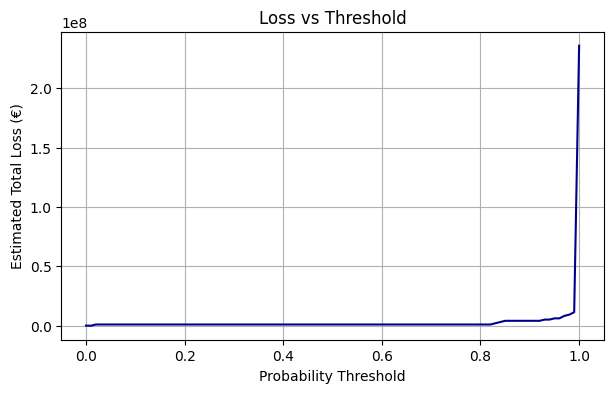

In [24]:
# Plotted estimated loss against probability threshold
plt.figure(figsize=(7,4))
plt.plot(thrs, losses, color='darkblue')
plt.xlabel('Probability Threshold')
plt.ylabel('Estimated Total Loss (€)')
plt.title('Loss vs Threshold')
plt.grid(True)
plt.show()


STEP 6: DEMO

In [25]:
!pip install gradio --quiet

import gradio as gr
import numpy as np
import pandas as pd

In [26]:
# Loaded saved model (no need to retrain)
xgb_model = joblib.load("xgb_fraud_model.joblib")

In [27]:
from sklearn.base import BaseEstimator, TransformerMixin

feature_cols = [
    'step','amount','oldbalanceOrg','newbalanceOrig','oldbalanceDest','newbalanceDest',
    'hour','day','balanceDiffOrig','balanceDiffDest','balanceChange',
    'type_CASH_OUT','type_DEBIT','type_PAYMENT','type_TRANSFER'
]

class FraudPreprocessor(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self  # no learned parameters

    def transform(self, X):
        # Accepted input: DataFrame with raw columns
        df = X.copy()

        # Derived time features
        df['hour'] = df['step'].astype(int) % 24
        df['day']  = df['step'].astype(int) // 24

        # Engineered numerical features
        df['balanceDiffOrig'] = df['oldbalanceOrg'] - df['newbalanceOrig']
        df['balanceDiffDest'] = df['newbalanceDest'] - df['oldbalanceDest']
        df['balanceChange']   = df['amount'] - df['balanceDiffOrig']

        # One-hot for 'type' with CASH_IN as baseline
        for col in ['type_CASH_OUT','type_DEBIT','type_PAYMENT','type_TRANSFER']:
            df[col] = 0
        # Accept either raw label (e.g., TRANSFER) or already prefixed key
        mask = df['type'].isin(['CASH_OUT','DEBIT','PAYMENT','TRANSFER'])
        df.loc[mask, ['type_CASH_OUT','type_DEBIT','type_PAYMENT','type_TRANSFER']] = 0
        df.loc[df['type']=='CASH_OUT','type_CASH_OUT'] = 1
        df.loc[df['type']=='DEBIT','type_DEBIT'] = 1
        df.loc[df['type']=='PAYMENT','type_PAYMENT'] = 1
        df.loc[df['type']=='TRANSFER','type_TRANSFER'] = 1

        # Return in exact training order; fill missing columns if any
        for c in feature_cols:
            if c not in df.columns:
                df[c] = 0
        return df[feature_cols]

In [28]:
from sklearn.pipeline import Pipeline

# Loaded the trained model (already fitted earlier)
xgb_model = joblib.load("xgb_fraud_model.joblib")

# Assembled the end-to-end pipeline (no refit needed)
pipe = Pipeline([
    ('prep', FraudPreprocessor()),
    ('clf', xgb_model)  # already trained
])

# Saved the full inference pipeline
joblib.dump(pipe, "fraud_inference_pipeline.joblib")


['fraud_inference_pipeline.joblib']

In [29]:
!pip install gradio --quiet

import gradio as gr
import pandas as pd
import joblib

# Loaded production pipeline (preprocessing + trained XGBoost)
pipe = joblib.load("fraud_inference_pipeline.joblib")

APP_NAME = "FraudShield"
APP_DESC = "Real-time fraud detection. Adjust the decision threshold to see how strict the detector is."
default_deploy_threshold = 0.01   # production rule (kept for notes)

# Helpers
def to_float(x): return float(str(x).strip()) if str(x).strip() != "" else 0.0
def to_int(x): return int(float(str(x).strip())) if str(x).strip() != "" else 0

# Result card
def render_card(proba, threshold):
    pct = round(proba * 100, 2)
    is_fraud = proba >= threshold
    color = "#ff4d4d" if is_fraud else "#00c853"
    shadow = "0 0 25px rgba(255,77,77,0.5)" if is_fraud else "0 0 25px rgba(0,200,83,0.5)"
    label = "⚠️ FRAUD DETECTED" if is_fraud else "✅ LEGIT TRANSACTION"
    subtitle = "Transaction flagged for manual review." if is_fraud else "Transaction cleared successfully."
    return f"""
    <div style="font-family: Inter, Arial, sans-serif; max-width: 720px; margin: 20px auto;">
      <div style="background:rgba(255,255,255,0.95); backdrop-filter:blur(10px);
                  border-radius:20px; padding:22px 26px; box-shadow:{shadow};">
        <div style="display:flex; justify-content:space-between; align-items:center;">
          <div style="font-size:22px; font-weight:700; color:{color}; letter-spacing:0.5px;">{label}</div>
          <div style="font-size:13px; color:#555;">Threshold: <b>{threshold:.2f}</b></div>
        </div>
        <div style="margin-top:16px; font-size:36px; font-weight:800; color:#111;">{pct}%</div>
        <div style="color:#555;">Fraud Probability</div>
        <div style="margin-top:8px; font-size:14px; color:#444;">{subtitle}</div>
        <div style="margin-top:18px; width:100%; height:8px; background:#eee; border-radius:6px;">
          <div style="height:8px; width:{pct}%; background:{color}; border-radius:6px;"></div>
        </div>
      </div>
    </div>
    """

# Inference
def predict_and_render(step_txt, ttype, amount_txt, oldOrg_txt, newOrig_txt, oldDest_txt, newDest_txt, thr):
    try:
        step = to_int(step_txt)
        amount = to_float(amount_txt)
        oldbalanceOrg = to_float(oldOrg_txt)
        newbalanceOrig = to_float(newOrig_txt)
        oldbalanceDest = to_float(oldDest_txt)
        newbalanceDest = to_float(newDest_txt)
    except:
        return "<div style='color:#ff4d4d;font-weight:600'>Please enter valid numeric values.</div>"

    row = pd.DataFrame([{
        "step": step,
        "type": ttype,
        "amount": amount,
        "oldbalanceOrg": oldbalanceOrg,
        "newbalanceOrig": newbalanceOrig,
        "oldbalanceDest": oldbalanceDest,
        "newbalanceDest": newbalanceDest,
    }])
    proba = float(pipe.predict_proba(row)[:, 1][0])
    return render_card(proba, thr)

# Header
HEADER_HTML = f"""
<div style="
  background:linear-gradient(90deg, #0d1b2a, #1b263b, #243b55);
  color:white; padding:16px 22px; border-radius:18px; margin-bottom:15px;
  display:flex; justify-content:space-between; align-items:center;
  font-family:Inter, Arial, sans-serif; box-shadow:0 2px 12px rgba(0,0,0,0.25);">
  <div style="font-size:22px; font-weight:700;">{APP_NAME}</div>
  <div style="background:linear-gradient(135deg, #64b5f6, #7df3d1);
              color:#0b1533; font-weight:800; padding:8px 14px;
              border-radius:999px; letter-spacing:0.5px;
              box-shadow:0 2px 10px rgba(0,0,0,0.3);">
    FraudShield
  </div>
</div>
<p style="color:#f0f0f0; font-family:Inter, Arial, sans-serif; margin:6px 4px 20px 4px; text-align:center;">
  {APP_DESC}
</p>
"""

# UI with threshold slider
with gr.Blocks(css=".gradio-container {background: linear-gradient(135deg, #1a237e, #3949ab, #283593);} .gr-button {font-weight:600;}") as demo:
    gr.HTML(HEADER_HTML)

    with gr.Row():
        with gr.Column(scale=5):
            step = gr.Textbox(label="Step (hour index)", value="1")
            ttype = gr.Dropdown(label="Transaction Type",
                                choices=["CASH_IN","CASH_OUT","DEBIT","PAYMENT","TRANSFER"],
                                value="TRANSFER")
            amount = gr.Textbox(label="Amount", value="1000")
            oldbalanceOrg = gr.Textbox(label="Old Balance (Origin)", value="1000")
            newbalanceOrig = gr.Textbox(label="New Balance (Origin)", value="0")
            oldbalanceDest = gr.Textbox(label="Old Balance (Destination)", value="0")
            newbalanceDest = gr.Textbox(label="New Balance (Destination)", value="0")

            threshold_slider = gr.Slider(0.01, 0.90, value=0.30, step=0.01, label="Decision Threshold (demo)")
            gr.Markdown(f"*Production rule kept at **{default_deploy_threshold:.2f}**; slider is for demo exploration.*")

            with gr.Row():
                btn = gr.Button("Predict", variant="primary")
                clear_btn = gr.Button("Clear")

            gr.Examples(
                examples=[
                    # likely LEGIT
                    ["3","PAYMENT","500","500","0","0","500"],
                    ["30","CASH_IN","750","0","750","1000","1750"],
                    # likely FRAUD
                    ["1","TRANSFER","20128","20128","0","0","0"],
                    ["12","CASH_OUT","2806","2806","0","26202","0"],
                ],
                inputs=[step, ttype, amount, oldbalanceOrg, newbalanceOrig, oldbalanceDest, newbalanceDest],
                label="Try Example Transactions"
            )

        with gr.Column(scale=5):
            result = gr.HTML()
            gr.Markdown(
                "### Decision Policy\n"
                "- Adjust the slider to make the detector stricter (higher) or more sensitive (lower).\n"
                "- Red card → predicted **FRAUD**; Green card → predicted **LEGIT**."
            )

    btn.click(
        fn=predict_and_render,
        inputs=[step, ttype, amount, oldbalanceOrg, newbalanceOrig, oldbalanceDest, newbalanceDest, threshold_slider],
        outputs=result
    )
    clear_btn.click(
        fn=lambda: ("","","","","","",""),
        inputs=None,
        outputs=[step, ttype, amount, oldbalanceOrg, newbalanceOrig, oldbalanceDest, newbalanceDest]
    )

demo.launch(share=True)

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://165a8c87146b46a306.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
